## Loading the dataset
After downloading the dataset from http://ufldl.stanford.edu/housenumbers/ in the second variant (32x32 images with a single number centered)

In [1]:
import matplotlib.pyplot as plt
import numpy as np, random, os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json

#Read the datasets into memory
from scipy.io import loadmat

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [2]:
#reshape the arrays to have the sample number as the first index

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [3]:
#label for 0 is 10, change to 0 the label for 0

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

### Convert from rgb to grayscale

In [4]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

In [5]:
train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

## Extract a random validation set from the training set
In this case the size of the validation set is 10% of the training set.  
It is randomly extracted because the order of the images in the training set it's not random: consecutive images are part of the same original image with a complete house number.

In [6]:
#Divide training and validation
#validation set size is 10% of training set
validation_percentage = 0.1
validation_size = int(validation_percentage * train_img.shape[0])
#select the validation set as a random sample from the training set
random.seed(0) #chosen seed so the set is always the same
sample = random.sample(range(train_img.shape[0]), validation_size)
validation_img = train_img[sample,:,:,:]
train_img = np.delete(train_img, sample, 0)
validation_lbs = train_lbs[sample,:]
train_lbs = np.delete(train_lbs, sample, 0)

train_img.shape, validation_img.shape, train_lbs.shape, validation_lbs.shape

((65932, 32, 32, 1), (7325, 32, 32, 1), (65932, 1), (7325, 1))

## Visualize the images

In [7]:
#Function to visualize image with their respective labels
def plot_img_grayscale(images, labels, rows=2, cols=8):
    plt.figure(figsize=(cols*2,rows*2))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,0], cmap='gray',vmin=0, vmax=255)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(labels[i][0])
    plt.show()

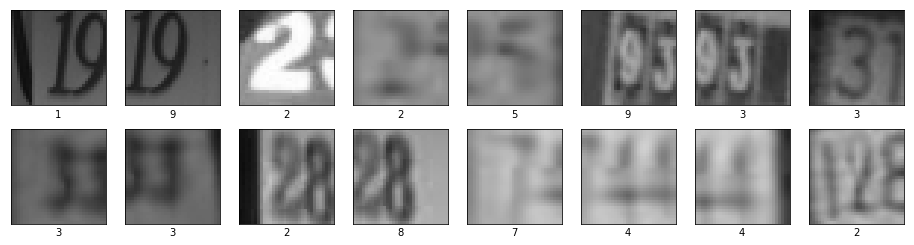

In [8]:
plot_img_grayscale(train_img, train_lbs)

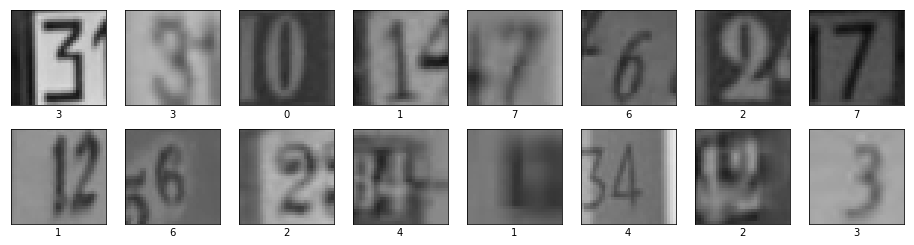

In [9]:
#Check if the validation set is divided correctely and print the data
plot_img_grayscale(validation_img, validation_lbs)

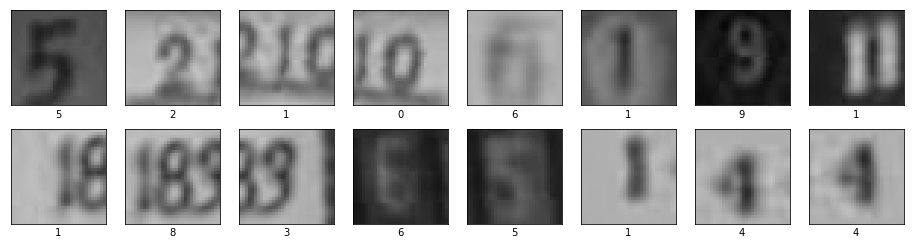

In [10]:
plot_img_grayscale(test_img, test_lbs)

## Data preprocessing

Two techniques are used in this order on the training set:

- **zero centering**: this is achieved by subctracting the mean of each colour channel (in this case just one beacuse the images are grayscaled) across said colour channel.
- **normalization**: divide each colour channel by its standard deviation (calculated after zero centering).

The same techniques are applied also on the validation set and test set but using the same parameters (mean and standard deviation) obtained from the training set.

In [11]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for validation and test set
validation_img = validation_img - train_mean
validation_img = validation_img / train_std
test_img = test_img - train_mean
test_img = test_img / train_std

## Hyper-parameters Optimization

In [12]:
##hyper parameters network structure, batch size, learning rate, drop-out

#do the train
#see what hyperparameters do better on val set
#redo the trainign with the best parameters on val set + train set
#evaluate on training set

#adapt network architecture:
#try max pool instead of stride or vice versa
#try global avarage pooling vs fully connected

In [13]:
#train on 6 epochs
epoch_num = 6

#default batch size
batch = 128

#allows to save the weights for a model in a directory called dir_name
def checkpoint(dir_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=dir_name+'/cp-{epoch:02d}.hd5', verbose=0, period=3)

#learning rate decay call back    
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [14]:
#define function to plot accuracy or loss
def plot_validation(history, loss=False):
    number_of_models = len(history)
    if loss:
        name, key, loc, f = 'Loss', 'loss', 'lower left', min
    else:
        name, key, loc, f = 'Accuracy', 'acc', 'upper left', max
    plt.figure(figsize=(8,3))
    for i in range(number_of_models):
        plt.plot(history[i].history['val_'+key], label='val_'+key+str(i))
        print('CNN {0}: Epochs={1:d}, Train {2}={3:.5f}, Validation {2}={4:.5f}'.format(
            i,epoch_num,name,f(history[i].history[key]),f(history[i].history['val_'+key])))
    plt.title('Validation '+ name)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend(loc='upper left')
    plt.show()

In [15]:
#funciton to get the index of the model with the best accuracy or loss
def get_best_model(history, loss=False):
    number_of_models = len(history)
    if loss:
        key = 'val_acc'
    else:
        key = 'val_loss'
    max_values = []
    for i in range(number_of_models):
        best_value = max([x for x in history[i].history[key]])
        max_values.append(best_value)
    return max_values.index(max(max_values))

In [16]:
def save_history(hist_list, path):
    if path != None:
        for i in range(len(hist_list)):
            json.dump(str(hist_list[i].history), open(path+str(i)+"/hist"+str(i)+".json", 'w'))
    
def load_history(path):
    return json.load(open(path, 'r'))

### Explain the basic structure on their hyper parameters
we are now going ot start hyperparameter evaluation

the basic network structure will be  
(conv2dLayer\* **N** (filterSize\* **L**) -> (maxPool or Stride))\***M** -> (FCnonlinear\***K** -> FCsoftmax) or (Global avarage pooling)

There are two typical architecture: conv layer followed by a max pooling or smaller conv layer followed by a conv layer with stride=2. Here the two are confronted giving each one roughly the same number of convolutional neurons.

### Validate the number of covolutional layers

In [17]:
val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 0:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    if i == 2 or i == 5:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i == 3 or i == 6:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/layers/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 10s 152us/sample - loss: 0.9167 - acc: 0.7192 - val_loss: 0.5774 - val_acc: 0.8362
Epoch 2/6
65932/65932 [==============================] - 10s 150us/sample - loss: 0.4987 - acc: 0.8592 - val_loss: 0.4625 - val_acc: 0.8721
Epoch 3/6
65932/65932 [==============================] - 10s 155us/sample - loss: 0.4133 - acc: 0.8819 - val_loss: 0.4423 - val_acc: 0.8689
Epoch 4/6
65932/65932 [==============================] - 10s 150us/sample - loss: 0.3591 - acc: 0.8959 - val_loss: 0.4000 - val_acc: 0.8861
Epoch 5/6
65932/65932 [==============================] - 10s 146us/sample - loss: 0.3170 - acc: 0.9067 - val_loss: 0.4177 - val_acc: 0.8790
Epoch 6/6
65932/65932 [==============================] - 10s 146us/sample - loss: 0.2834 - acc: 0.9182 - val_loss: 0.4018 - val_acc: 0.8859
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 31s 4

CNN 0: Epochs=6, Train Accuracy=0.91816, Validation Accuracy=0.88614
CNN 1: Epochs=6, Train Accuracy=0.93372, Validation Accuracy=0.90430
CNN 2: Epochs=6, Train Accuracy=0.94784, Validation Accuracy=0.90990
CNN 3: Epochs=6, Train Accuracy=0.96179, Validation Accuracy=0.91113
CNN 4: Epochs=6, Train Accuracy=0.95225, Validation Accuracy=0.90853
CNN 5: Epochs=6, Train Accuracy=0.93724, Validation Accuracy=0.91836
CNN 6: Epochs=6, Train Accuracy=0.95738, Validation Accuracy=0.91208


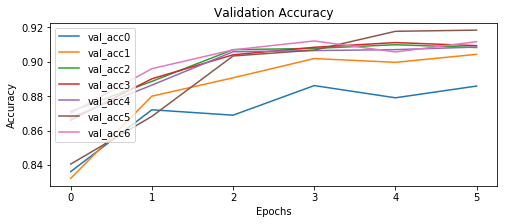

CNN 0: Epochs=6, Train Loss=0.28340, Validation Loss=0.40000
CNN 1: Epochs=6, Train Loss=0.22653, Validation Loss=0.32253
CNN 2: Epochs=6, Train Loss=0.17964, Validation Loss=0.29777
CNN 3: Epochs=6, Train Loss=0.13295, Validation Loss=0.32154
CNN 4: Epochs=6, Train Loss=0.16585, Validation Loss=0.30905
CNN 5: Epochs=6, Train Loss=0.21481, Validation Loss=0.27536
CNN 6: Epochs=6, Train Loss=0.14565, Validation Loss=0.29930


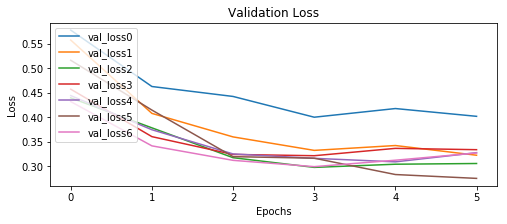

In [19]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [20]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 5 is the best one
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 3

### Validate max-pool over stride2

In [23]:
val_models = []

models_number = 2
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i == 0:
        model.add(layers.MaxPooling2D())
    else:
        model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i ==0:
        model.add(layers.MaxPooling2D())
    else:
        model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [24]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/layers/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 56s 853us/sample - loss: 0.8274 - acc: 0.7342 - val_loss: 0.4485 - val_acc: 0.8707
Epoch 2/6
65932/65932 [==============================] - 57s 868us/sample - loss: 0.3592 - acc: 0.8933 - val_loss: 0.3531 - val_acc: 0.8935
Epoch 3/6
65932/65932 [==============================] - 57s 868us/sample - loss: 0.2829 - acc: 0.9167 - val_loss: 0.3196 - val_acc: 0.9053
Epoch 4/6
65932/65932 [==============================] - 56s 852us/sample - loss: 0.2360 - acc: 0.9305 - val_loss: 0.2950 - val_acc: 0.9163
Epoch 5/6
65932/65932 [==============================] - 57s 866us/sample - loss: 0.2056 - acc: 0.9406 - val_loss: 0.2952 - val_acc: 0.9140
Epoch 6/6
65932/65932 [==============================] - 57s 860us/sample - loss: 0.1738 - acc: 0.9508 - val_loss: 0.2858 - val_acc: 0.9200
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 56s 8

CNN 0: Epochs=6, Train Accuracy=0.95075, Validation Accuracy=0.92000
CNN 1: Epochs=6, Train Accuracy=0.94092, Validation Accuracy=0.91031


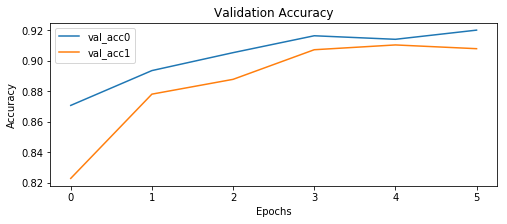

CNN 0: Epochs=6, Train Loss=0.17383, Validation Loss=0.28575
CNN 1: Epochs=6, Train Loss=0.19789, Validation Loss=0.30565


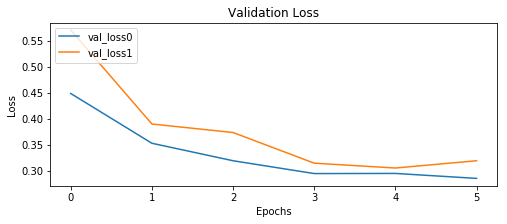

In [25]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [26]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 0 is the best one
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 3

### Validate the number of filters per layer

In [27]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(8+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(16+8*i, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [ ]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/filters/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 27s 406us/sample - loss: 0.9179 - acc: 0.7022 - val_loss: 0.5213 - val_acc: 0.8427
Epoch 2/6
 1920/65932 [..............................] - ETA: 25s - loss: 0.4881 - acc: 0.8510

CNN 0: Epochs=6, Train Accuracy=0.93433, Validation Accuracy=0.89898
CNN 1: Epochs=6, Train Accuracy=0.95238, Validation Accuracy=0.91672
CNN 2: Epochs=6, Train Accuracy=0.95982, Validation Accuracy=0.91891
CNN 3: Epochs=6, Train Accuracy=0.95950, Validation Accuracy=0.92246
CNN 4: Epochs=6, Train Accuracy=0.96407, Validation Accuracy=0.92355
CNN 5: Epochs=6, Train Accuracy=0.18910, Validation Accuracy=0.19017


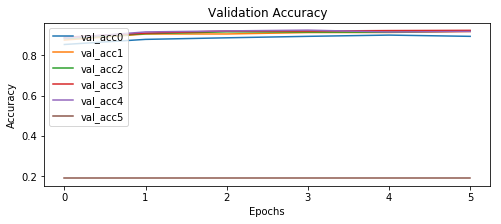

CNN 0: Epochs=6, Train Loss=0.21890, Validation Loss=0.34877
CNN 1: Epochs=6, Train Loss=0.16269, Validation Loss=0.30594
CNN 2: Epochs=6, Train Loss=0.13415, Validation Loss=0.29273
CNN 3: Epochs=6, Train Loss=0.14098, Validation Loss=0.27130
CNN 4: Epochs=6, Train Loss=0.12394, Validation Loss=0.27601
CNN 5: Epochs=6, Train Loss=2.23688, Validation Loss=2.23566


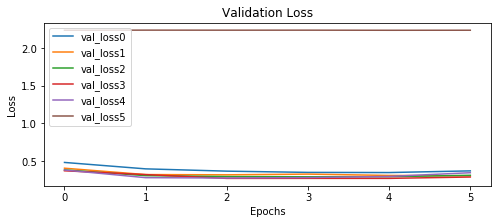

In [30]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [31]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 4 is the best one
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_132 (Conv2D)          (None, 32, 32, 40)        400       
_________________________________________________________________
conv2d_133 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_134 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 15, 15, 40)        14440     
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 15, 15, 80)        28880     
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 15, 15, 80)        57680     
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 15, 15, 8

In [13]:
#first layer weights
flw = 8+8*best
#second layer weights
slw = 16+16*best

### Validate the number neurons in the fully connected layer

In [33]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(64+64*i, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [34]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/FC/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 192s 3ms/sample - loss: 0.8732 - acc: 0.7137 - val_loss: 0.4223 - val_acc: 0.8718
Epoch 2/6
65932/65932 [==============================] - 197s 3ms/sample - loss: 0.3411 - acc: 0.8986 - val_loss: 0.3058 - val_acc: 0.9072
Epoch 3/6
65932/65932 [==============================] - 202s 3ms/sample - loss: 0.2710 - acc: 0.9211 - val_loss: 0.2984 - val_acc: 0.9122
Epoch 4/6
65932/65932 [==============================] - 191s 3ms/sample - loss: 0.2313 - acc: 0.9329 - val_loss: 0.2723 - val_acc: 0.9210
Epoch 5/6
65932/65932 [==============================] - 198s 3ms/sample - loss: 0.1977 - acc: 0.9430 - val_loss: 0.2701 - val_acc: 0.9263
Epoch 6/6
65932/65932 [==============================] - 197s 3ms/sample - loss: 0.1692 - acc: 0.9514 - val_loss: 0.2973 - val_acc: 0.9182
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 199s 3ms/sa

CNN 0: Epochs=6, Train Accuracy=0.95136, Validation Accuracy=0.92628
CNN 1: Epochs=6, Train Accuracy=0.95959, Validation Accuracy=0.92068
CNN 2: Epochs=6, Train Accuracy=0.95817, Validation Accuracy=0.91986
CNN 3: Epochs=6, Train Accuracy=0.96546, Validation Accuracy=0.92382
CNN 4: Epochs=6, Train Accuracy=0.96469, Validation Accuracy=0.91659


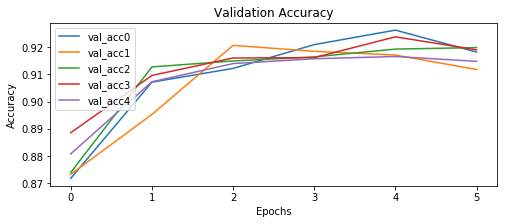

CNN 0: Epochs=6, Train Loss=0.16921, Validation Loss=0.27008
CNN 1: Epochs=6, Train Loss=0.13685, Validation Loss=0.27507
CNN 2: Epochs=6, Train Loss=0.13929, Validation Loss=0.27556
CNN 3: Epochs=6, Train Loss=0.11566, Validation Loss=0.26993
CNN 4: Epochs=6, Train Loss=0.11746, Validation Loss=0.28238


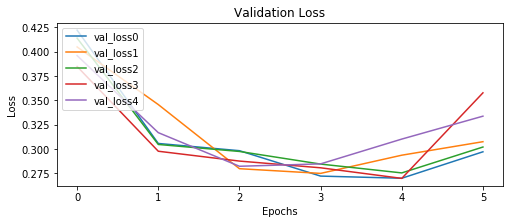

In [35]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [36]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 0 is the best one
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 32, 32, 40)        400       
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 15, 15, 40)        14440     
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 15, 15, 80)        28880     
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 15, 15, 80)        57680     
_________________________________________________________________
conv2d_154 (Conv2D)          (None, 15, 15, 8

In [15]:
#fully connected layer weights
fcw = 64+best*64

### Validate the batch size

In [33]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dropout(best_dropout))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [35]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/batch/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=24+i*24, epochs=epoch_num+3,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/9
  672/65932 [..............................] - ETA: 3:07 - loss: 0.1873 - acc: 0.9524

KeyboardInterrupt: 

In [ ]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

In [ ]:
best_batch_size = 24+best*24

### Validate Learning rate

In [ ]:
val_models = []

models_number = 5
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dropout(best_dropout))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [ ]:
#create multiple learning rates
def lrd(i):
    return tf.keras.callbacks.LearningRateScheduler(lambda x: 10**-3 * (0.65 - (0.025*i )) ** x, verbose=0)

In [ ]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/learning_rate/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=best_batch_size, epochs=epoch_num+2+i,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  lrd(i)]))

In [ ]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [ ]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

In [ ]:
best_lr = lrd(best)

### Validate droput

In [18]:
val_models = []

dropout = [0.1,0.2,0.3,0.4,0.5,0.6]

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dropout(dropout[i]))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [39]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/dropout/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 186s 3ms/sample - loss: 0.7821 - acc: 0.7470 - val_loss: 0.3659 - val_acc: 0.8930
Epoch 2/6
65932/65932 [==============================] - 183s 3ms/sample - loss: 0.3473 - acc: 0.8984 - val_loss: 0.3320 - val_acc: 0.8984
Epoch 3/6
65932/65932 [==============================] - 188s 3ms/sample - loss: 0.2814 - acc: 0.9172 - val_loss: 0.3044 - val_acc: 0.9089
Epoch 4/6
65932/65932 [==============================] - 188s 3ms/sample - loss: 0.2343 - acc: 0.9330 - val_loss: 0.3064 - val_acc: 0.9114
Epoch 5/6
65932/65932 [==============================] - 189s 3ms/sample - loss: 0.1986 - acc: 0.9420 - val_loss: 0.2742 - val_acc: 0.9200
Epoch 6/6
65932/65932 [==============================] - 187s 3ms/sample - loss: 0.1677 - acc: 0.9512 - val_loss: 0.3132 - val_acc: 0.9156
Train on 65932 samples, validate on 7325 samples
Epoch 1/6
65932/65932 [==============================] - 187s 3ms/sa

CNN 0: Epochs=6, Train Accuracy=0.95116, Validation Accuracy=0.92000
CNN 1: Epochs=6, Train Accuracy=0.94469, Validation Accuracy=0.92109
CNN 2: Epochs=6, Train Accuracy=0.93445, Validation Accuracy=0.91809
CNN 3: Epochs=6, Train Accuracy=0.92479, Validation Accuracy=0.91945
CNN 4: Epochs=6, Train Accuracy=0.92465, Validation Accuracy=0.92423
CNN 5: Epochs=6, Train Accuracy=0.90980, Validation Accuracy=0.92396


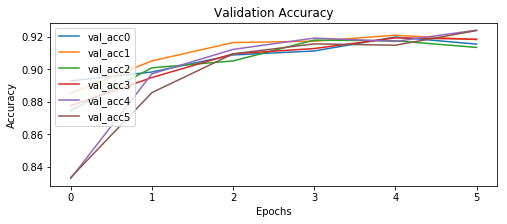

CNN 0: Epochs=6, Train Loss=0.16775, Validation Loss=0.27420
CNN 1: Epochs=6, Train Loss=0.19597, Validation Loss=0.27990
CNN 2: Epochs=6, Train Loss=0.22570, Validation Loss=0.29314
CNN 3: Epochs=6, Train Loss=0.26093, Validation Loss=0.28610
CNN 4: Epochs=6, Train Loss=0.26982, Validation Loss=0.27945
CNN 5: Epochs=6, Train Loss=0.32172, Validation Loss=0.28744


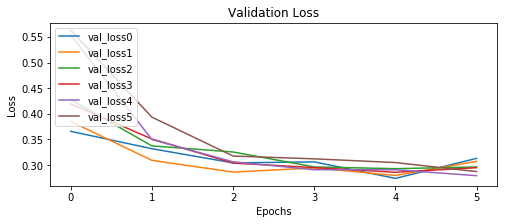

In [40]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [41]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 4 is the best one
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 32, 32, 40)        400       
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 15, 15, 40)        14440     
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 15, 15, 80)        28880     
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 15, 15, 80)        57680     
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 15, 15, 8

In [20]:
best_dropout = dropout[best]

### Validate L2 regularization

In [73]:
val_models = []

reg_factor = [0.00001,0.00005,0.0001,0.0005]

models_number = 4
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1),
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))

    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(fcw, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [74]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/l2_reg/var'
for i in range(models_number):
    os.makedirs(base_name+str(i), exist_ok=True)

for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch, epochs=epoch_num+5,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=[checkpoint(base_name+str(i)),
                                                  learning_rate]))

Train on 65932 samples, validate on 7325 samples
Epoch 1/11
65932/65932 [==============================] - 193s 3ms/sample - loss: 1.0123 - acc: 0.6621 - val_loss: 0.4668 - val_acc: 0.8564
Epoch 2/11
65932/65932 [==============================] - 192s 3ms/sample - loss: 0.3819 - acc: 0.8869 - val_loss: 0.3520 - val_acc: 0.8964
Epoch 3/11
65932/65932 [==============================] - 197s 3ms/sample - loss: 0.2959 - acc: 0.9151 - val_loss: 0.2975 - val_acc: 0.9134
Epoch 4/11
65932/65932 [==============================] - 202s 3ms/sample - loss: 0.2510 - acc: 0.9284 - val_loss: 0.2805 - val_acc: 0.9155
Epoch 5/11
65932/65932 [==============================] - 193s 3ms/sample - loss: 0.2211 - acc: 0.9383 - val_loss: 0.2880 - val_acc: 0.9180
Epoch 6/11
65932/65932 [==============================] - 196s 3ms/sample - loss: 0.1945 - acc: 0.9450 - val_loss: 0.3034 - val_acc: 0.9184
Epoch 7/11
30464/65932 [============>.................] - ETA: 1:41 - loss: 0.1568 - acc: 0.9560

KeyboardInterrupt: 

CNN 0: Epochs=6, Train Accuracy=0.95116, Validation Accuracy=0.92000
CNN 1: Epochs=6, Train Accuracy=0.94469, Validation Accuracy=0.92109
CNN 2: Epochs=6, Train Accuracy=0.93445, Validation Accuracy=0.91809
CNN 3: Epochs=6, Train Accuracy=0.92479, Validation Accuracy=0.91945
CNN 4: Epochs=6, Train Accuracy=0.92465, Validation Accuracy=0.92423
CNN 5: Epochs=6, Train Accuracy=0.90980, Validation Accuracy=0.92396


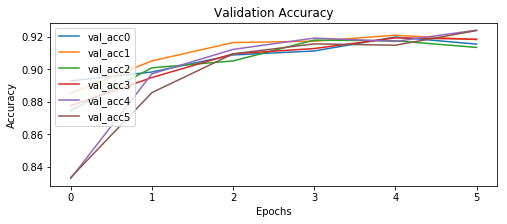

CNN 0: Epochs=6, Train Loss=0.16775, Validation Loss=0.27420
CNN 1: Epochs=6, Train Loss=0.19597, Validation Loss=0.27990
CNN 2: Epochs=6, Train Loss=0.22570, Validation Loss=0.29314
CNN 3: Epochs=6, Train Loss=0.26093, Validation Loss=0.28610
CNN 4: Epochs=6, Train Loss=0.26982, Validation Loss=0.27945
CNN 5: Epochs=6, Train Loss=0.32172, Validation Loss=0.28744


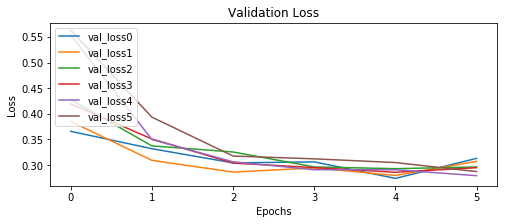

In [40]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [41]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 4 is the best one
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 32, 32, 40)        400       
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 32, 32, 40)        14440     
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 15, 15, 40)        14440     
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 15, 15, 80)        28880     
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 15, 15, 80)        57680     
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 15, 15, 8

In [20]:
best_l2_reg = reg_factor[best]

### Train the model on the whole training set (train + validation renormalized)

In [ ]:
#reload the datasets and renormalize them, without splitting the validation set.
train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

In [ ]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

In [ ]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for the test set
test_img = test_img - train_mean
test_img = test_img / train_std

In [ ]:
#create the final model
model = models.Sequential()
    
model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(flw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(flw, (3,3), strides=2, activation='relu'))

model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(slw, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(slw, (3,3), strides=2, activation='relu'))
        
model.add(layers.Flatten())
model.add(layers.Dense(fcw, activation='relu'))
model.add(layers.Dropout(best_dropout))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/training/model'
os.makedirs(base_name, exist_ok=True)

#train it
history = model.fit(train_img, train_lbs, batch_size=best_batch_size, epochs=10, validation_data=(test_img, test_lbs),
                    verbose = 1, callbacks=[checkpoint(base_name), best_lr])

In [ ]:
save_history([history], base_name)

plot_validation([history])

plot_validation([history], loss=True)

In [ ]:
model.evaluate(test_img, test_lbs)